## Učitavanje podataka

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [5]:
data = pd.read_csv('data.csv')

In [6]:
data.drop(columns=['Unnamed: 0'], inplace = True)

In [7]:
y = data.iloc[:, -1]
X = data.iloc[:, :data.shape[1] - 1]

### Pravljenje atributa i metrika za evaluaciju i izbor najboljeg modela

In [8]:
cnn_par_f = {
    'window': [3, 7, 11],
    'dropout': [0.1, 0.2, 0.5]
}

In [35]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

In [37]:
filter_cnn = 64
num_classes = len(np.unique(y))
epochs = 25
K=10
pool = 3
classes = np.unique(y)

In [38]:
num_classes

5

In [11]:
scoring = {'f1_macro' : 'f1_macro', 'accuracy' : 'accuracy'}
for c in classes:
    def f1_class(y_true, y_pred, classes, c=c):
        return metrics.f1_score(y_true, y_pred, average=None)[c-1]
    scoring_name = 'f1_class_%d' % c
    scoring[scoring_name] = metrics.make_scorer(f1_class, classes = classes)

### Podela podataka na trening i testni skup, standardizacija i Furijeova transformacija

In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, stratify = y,random_state = 1996)

In [13]:
from sklearn import preprocessing
scaler_train = preprocessing.StandardScaler()
scaler_train.fit(X_train)
X_train = scaler_train.transform(X_train)
X_test = scaler_train.transform(X_test)

In [15]:
print(X_train.shape, X_test.shape)

(8050, 178) (3450, 178)


In [18]:
X_train_fft = np.fft.rfft(X_train, axis=1).astype(float)
X_test_fft = np.fft.rfft(X_test, axis=1).astype(float)

C:\Users\vbakarevic\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.
C:\Users\vbakarevic\anaconda3\lib\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [19]:
print(X_train_fft.shape, X_test_fft.shape)

(8050, 90) (3450, 90)


In [21]:
X_train_fft = np.array(X_train_fft)
X_test_fft = np.array(X_test_fft)
X_train_fft = X_train_fft.reshape(X_train_fft.shape[0], X_train_fft.shape[1], 1)
X_test_fft = X_test_fft.reshape(X_test_fft.shape[0], X_test_fft.shape[1], 1)

In [22]:
print(X_train_fft.shape, X_test_fft.shape)

(8050, 90, 1) (3450, 90, 1)


### Pravljenje mreže i izbor najboljeg modela unakrsnom validacijom

In [24]:
input_shape = (X_train_fft.shape[1], 1)
input_shape

(90, 1)

In [39]:
def mreza(input_shape, num_classes,window, dropout):
    model = Sequential()
    model.add(Conv1D(filter_cnn, window, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filter_cnn, window, activation='relu'))
    model.add(MaxPooling1D(pool))
    model.add(Conv1D(filter_cnn * 2, window, activation='relu'))
    model.add(Conv1D(filter_cnn * 2, window, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [43]:
from keras.wrappers.scikit_learn  import KerasClassifier
def get_estimator(window=3,dropout=0.5):
    return KerasClassifier(build_fn=mreza,input_shape=input_shape, num_classes=num_classes,window=window, dropout=dropout, epochs = epochs)

In [44]:
estimator = get_estimator()
grid_f_cnn = model_selection.GridSearchCV(estimator, param_grid=cnn_par_f, scoring=scoring, cv=K, refit='accuracy', return_train_score=True)

In [45]:
grid_f_cnn.fit(X_train_fft, y_train)

Epoch 1/25
7245/7245 [==============================] - 7s 937us/step - loss: 1.0599 - accuracy: 0.5281
Epoch 2/25
7245/7245 [==============================] - 6s 780us/step - loss: 0.8583 - accuracy: 0.6189
Epoch 3/25
7245/7245 [==============================] - 6s 796us/step - loss: 0.7940 - accuracy: 0.6454
Epoch 4/25
7245/7245 [==============================] - 6s 785us/step - loss: 0.7698 - accuracy: 0.6523
Epoch 5/25
7245/7245 [==============================] - 6s 781us/step - loss: 0.7527 - accuracy: 0.6545
Epoch 6/25
7245/7245 [==============================] - 6s 780us/step - loss: 0.7318 - accuracy: 0.6679
Epoch 7/25
7245/7245 [==============================] - 6s 780us/step - loss: 0.7129 - accuracy: 0.6754
Epoch 8/25
7245/7245 [==============================] - 6s 818us/step - loss: 0.6987 - accuracy: 0.6740
Epoch 9/25
7245/7245 [==============================] - 6s 814us/step - loss: 0.6838 - accuracy: 0.6842
Epoch 10/25
7245/7245 [==============================] - 6s 820u

7245/7245 [==============================] - 6s 843us/step - loss: 0.6995 - accuracy: 0.6696
Epoch 8/25
7245/7245 [==============================] - 6s 843us/step - loss: 0.6932 - accuracy: 0.6790
Epoch 9/25
7245/7245 [==============================] - 6s 850us/step - loss: 0.6696 - accuracy: 0.6893
Epoch 10/25
7245/7245 [==============================] - 6s 842us/step - loss: 0.6526 - accuracy: 0.7026
Epoch 11/25
7245/7245 [==============================] - 6s 844us/step - loss: 0.6304 - accuracy: 0.6977
Epoch 12/25
7245/7245 [==============================] - 6s 845us/step - loss: 0.6214 - accuracy: 0.7132
Epoch 13/25
7245/7245 [==============================] - 6s 856us/step - loss: 0.6043 - accuracy: 0.7239
Epoch 14/25
7245/7245 [==============================] - 6s 865us/step - loss: 0.6023 - accuracy: 0.7224
Epoch 15/25
7245/7245 [==============================] - 6s 845us/step - loss: 0.5987 - accuracy: 0.7303
Epoch 16/25
7245/7245 [==============================] - 6s 846us/ste

7245/7245 [==============================] - 8s 1ms/step - loss: 0.4499 - accuracy: 0.7850
Epoch 15/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.4177 - accuracy: 0.8021
Epoch 16/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.4063 - accuracy: 0.8099
Epoch 17/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.3876 - accuracy: 0.8186
Epoch 18/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.3749 - accuracy: 0.8228
Epoch 19/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.3558 - accuracy: 0.8385
Epoch 20/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.3315 - accuracy: 0.8455
Epoch 21/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.3676 - accuracy: 0.8427
Epoch 22/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.3383 - accuracy: 0.8453
Epoch 23/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.2766 -

7245/7245 [==============================] - 8s 1ms/step - loss: 0.3459 - accuracy: 0.8422
Epoch 23/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.3285 - accuracy: 0.8478
Epoch 24/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.3065 - accuracy: 0.8555
Epoch 25/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.2918 - accuracy: 0.8669
Epoch 1/25
7245/7245 [==============================] - 10s 1ms/step - loss: 1.0314 - accuracy: 0.5418
Epoch 2/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.7678 - accuracy: 0.6541
Epoch 3/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6839 - accuracy: 0.6874
Epoch 4/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6329 - accuracy: 0.7021
Epoch 5/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5918 - accuracy: 0.7159
Epoch 6/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5788 - accu

7245/7245 [==============================] - 9s 1ms/step - loss: 0.5418 - accuracy: 0.7369
Epoch 6/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.5113 - accuracy: 0.7549
Epoch 7/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.4915 - accuracy: 0.7601
Epoch 8/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.4557 - accuracy: 0.7735
Epoch 9/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.4451 - accuracy: 0.7845
Epoch 10/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.4266 - accuracy: 0.7965
Epoch 11/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.4249 - accuracy: 0.7914
Epoch 12/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.3852 - accuracy: 0.8217
Epoch 13/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.3396 - accuracy: 0.8324
Epoch 14/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.3390 - acc

7245/7245 [==============================] - 8s 1ms/step - loss: 0.6458 - accuracy: 0.7023
Epoch 14/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6363 - accuracy: 0.7096
Epoch 15/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6206 - accuracy: 0.7101
Epoch 16/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6155 - accuracy: 0.7158
Epoch 17/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6107 - accuracy: 0.7238
Epoch 18/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5733 - accuracy: 0.7383
Epoch 19/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5705 - accuracy: 0.7406
Epoch 20/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5600 - accuracy: 0.7438
Epoch 21/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5758 - accuracy: 0.7390
Epoch 22/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5320 -

7245/7245 [==============================] - 8s 1ms/step - loss: 0.5248 - accuracy: 0.7587
Epoch 22/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5587 - accuracy: 0.7456
Epoch 23/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5187 - accuracy: 0.7694
Epoch 24/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5021 - accuracy: 0.7741
Epoch 25/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.4876 - accuracy: 0.7855
Epoch 1/25
7245/7245 [==============================] - 10s 1ms/step - loss: 1.0698 - accuracy: 0.5153
Epoch 2/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.8463 - accuracy: 0.6207
Epoch 3/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.8087 - accuracy: 0.6316
Epoch 4/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.7708 - accuracy: 0.6462
Epoch 5/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.7611 - acc

7245/7245 [==============================] - 10s 1ms/step - loss: 0.6443 - accuracy: 0.6918
Epoch 5/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.6302 - accuracy: 0.6959
Epoch 6/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.6065 - accuracy: 0.7038
Epoch 7/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.5757 - accuracy: 0.7230
Epoch 8/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.5670 - accuracy: 0.7277
Epoch 9/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.5444 - accuracy: 0.7360
Epoch 10/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.5271 - accuracy: 0.7426
Epoch 11/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.5157 - accuracy: 0.7528
Epoch 12/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.4969 - accuracy: 0.7611
Epoch 13/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.4

7245/7245 [==============================] - 11s 1ms/step - loss: 0.4156 - accuracy: 0.7981
Epoch 13/25
7245/7245 [==============================] - 11s 1ms/step - loss: 0.4086 - accuracy: 0.8032
Epoch 14/25
7245/7245 [==============================] - 11s 2ms/step - loss: 0.3668 - accuracy: 0.8236
Epoch 15/25
7245/7245 [==============================] - 11s 2ms/step - loss: 0.3636 - accuracy: 0.8225
Epoch 16/25
7245/7245 [==============================] - 11s 2ms/step - loss: 0.3683 - accuracy: 0.8253
Epoch 17/25
7245/7245 [==============================] - 11s 2ms/step - loss: 0.3082 - accuracy: 0.8480
Epoch 18/25
7245/7245 [==============================] - 11s 2ms/step - loss: 0.3135 - accuracy: 0.8490
Epoch 19/25
7245/7245 [==============================] - 11s 1ms/step - loss: 0.3073 - accuracy: 0.8573
Epoch 20/25
7245/7245 [==============================] - 11s 2ms/step - loss: 0.2657 - accuracy: 0.8754
Epoch 21/25
7245/7245 [==============================] - 11s 2ms/step - loss

7245/7245 [==============================] - 11s 2ms/step - loss: 0.2581 - accuracy: 0.8818
Epoch 21/25
7245/7245 [==============================] - 12s 2ms/step - loss: 0.2289 - accuracy: 0.8919
Epoch 22/25
7245/7245 [==============================] - 12s 2ms/step - loss: 0.2041 - accuracy: 0.9096
Epoch 23/25
7245/7245 [==============================] - 11s 2ms/step - loss: 0.1796 - accuracy: 0.9190
Epoch 24/25
7245/7245 [==============================] - 12s 2ms/step - loss: 0.1586 - accuracy: 0.9264
Epoch 25/25
7245/7245 [==============================] - 12s 2ms/step - loss: 0.1698 - accuracy: 0.9264
Epoch 1/25
7245/7245 [==============================] - 14s 2ms/step - loss: 0.9681 - accuracy: 0.5579
Epoch 2/25
7245/7245 [==============================] - 11s 2ms/step - loss: 0.6650 - accuracy: 0.6897
Epoch 3/25
7245/7245 [==============================] - 11s 2ms/step - loss: 0.5972 - accuracy: 0.7153
Epoch 4/25
7245/7245 [==============================] - 11s 2ms/step - loss: 0.

7245/7245 [==============================] - 10s 1ms/step - loss: 0.8662 - accuracy: 0.6124
Epoch 4/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.8383 - accuracy: 0.6231
Epoch 5/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.8024 - accuracy: 0.6381
Epoch 6/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.7870 - accuracy: 0.6429
Epoch 7/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.7600 - accuracy: 0.6498
Epoch 8/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.7756 - accuracy: 0.6494
Epoch 9/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.7525 - accuracy: 0.6555
Epoch 10/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.7289 - accuracy: 0.6676
Epoch 11/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.7462 - accuracy: 0.6622
Epoch 12/25
7245/7245 [==============================] - 10s 1ms/step - loss: 0.71

7245/7245 [==============================] - 11s 1ms/step - loss: 0.7281 - accuracy: 0.6723
Epoch 12/25
7245/7245 [==============================] - 11s 1ms/step - loss: 0.6990 - accuracy: 0.6863
Epoch 13/25
7245/7245 [==============================] - 11s 1ms/step - loss: 0.6943 - accuracy: 0.6867
Epoch 14/25
7245/7245 [==============================] - 11s 1ms/step - loss: 0.6877 - accuracy: 0.6908
Epoch 15/25
7245/7245 [==============================] - 11s 1ms/step - loss: 0.6729 - accuracy: 0.6919
Epoch 16/25
7245/7245 [==============================] - 11s 1ms/step - loss: 0.6724 - accuracy: 0.6893
Epoch 17/25
7245/7245 [==============================] - 11s 1ms/step - loss: 0.6581 - accuracy: 0.7053
Epoch 18/25
7245/7245 [==============================] - 11s 1ms/step - loss: 0.6343 - accuracy: 0.7078
Epoch 19/25
7245/7245 [==============================] - 11s 1ms/step - loss: 0.6306 - accuracy: 0.7125
Epoch 20/25
7245/7245 [==============================] - 11s 1ms/step - loss

7245/7245 [==============================] - 13s 2ms/step - loss: 0.4242 - accuracy: 0.7923
Epoch 20/25
7245/7245 [==============================] - 13s 2ms/step - loss: 0.4316 - accuracy: 0.7971
Epoch 21/25
7245/7245 [==============================] - 13s 2ms/step - loss: 0.4155 - accuracy: 0.7971
Epoch 22/25
7245/7245 [==============================] - 13s 2ms/step - loss: 0.3894 - accuracy: 0.8086
Epoch 23/25
7245/7245 [==============================] - 13s 2ms/step - loss: 0.3937 - accuracy: 0.8142
Epoch 24/25
7245/7245 [==============================] - 13s 2ms/step - loss: 0.3601 - accuracy: 0.8214
Epoch 25/25
7245/7245 [==============================] - 13s 2ms/step - loss: 0.3690 - accuracy: 0.8255
Epoch 1/25
7245/7245 [==============================] - 16s 2ms/step - loss: 1.1268 - accuracy: 0.4860
Epoch 2/25
7245/7245 [==============================] - 13s 2ms/step - loss: 0.8687 - accuracy: 0.6168
Epoch 3/25
7245/7245 [==============================] - 13s 2ms/step - loss: 0

7245/7245 [==============================] - 14s 2ms/step - loss: 0.7009 - accuracy: 0.6772
Epoch 3/25
7245/7245 [==============================] - 14s 2ms/step - loss: 0.6364 - accuracy: 0.6937
Epoch 4/25
7245/7245 [==============================] - 14s 2ms/step - loss: 0.6015 - accuracy: 0.7082
Epoch 5/25
7245/7245 [==============================] - 14s 2ms/step - loss: 0.5842 - accuracy: 0.7143
Epoch 6/25
7245/7245 [==============================] - 14s 2ms/step - loss: 0.5694 - accuracy: 0.7231
Epoch 7/25
7245/7245 [==============================] - 14s 2ms/step - loss: 0.5530 - accuracy: 0.7342
Epoch 8/25
7245/7245 [==============================] - 14s 2ms/step - loss: 0.5260 - accuracy: 0.7409
Epoch 9/25
7245/7245 [==============================] - 14s 2ms/step - loss: 0.5175 - accuracy: 0.7545
Epoch 10/25
7245/7245 [==============================] - 14s 2ms/step - loss: 0.5059 - accuracy: 0.7493
Epoch 11/25
7245/7245 [==============================] - 14s 2ms/step - loss: 0.478

7245/7245 [==============================] - 15s 2ms/step - loss: 0.5396 - accuracy: 0.7346
Epoch 10/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.5261 - accuracy: 0.7393
Epoch 11/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.5078 - accuracy: 0.7520
Epoch 12/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.4776 - accuracy: 0.7640
Epoch 13/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.4921 - accuracy: 0.7601
Epoch 14/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.4676 - accuracy: 0.7666
Epoch 15/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.4504 - accuracy: 0.7745
Epoch 16/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.4221 - accuracy: 0.7866
Epoch 17/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.3922 - accuracy: 0.8025
Epoch 18/25
7245/7245 [==============================] - 15s 2ms/step - loss

GridSearchCV(cv=10, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000023CACD69FD0>,
             iid='deprecated', n_jobs=None,
             param_grid={'dropout': [0.1, 0.2, 0.5], 'window': [3, 7, 11]},
             pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'f1_class_1': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_class_2': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_class_3': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_class_4': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_class_5': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_macro': 'f1_macro'},
             verbose=0)

In [46]:
grid_f_cnn.best_params_

{'dropout': 0.2, 'window': 7}

In [48]:
grid_f_cnn.best_score_

0.7469565217391304

### Rezultati unakrsne validacije

In [51]:
grid_f_cnn_results =pd.DataFrame(grid_f_cnn.cv_results_)
print(grid_f_cnn_results)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_dropout  \
0     166.553181      5.448159         3.402238        0.189330           0.1   
1     215.702619      5.782552         4.111922        0.220646           0.1   
2     239.432600      7.366358         4.792014        0.200890           0.1   
3     218.364463      6.791688         5.590700        0.250550           0.2   
4     272.529417      7.798654         6.412987        0.259565           0.2   
5     306.060310     12.415061         7.277373        0.309104           0.2   
6     288.645937      8.399069         8.351752        0.361654           0.5   
7     353.287802      7.603029         9.367235        0.337211           0.5   
8     395.925554     11.649895        10.347327        0.344337           0.5   

  param_window                          params  split0_test_f1_macro  \
0            3   {'dropout': 0.1, 'window': 3}              0.714920   
1            7   {'dropout': 0.1, 'window': 7

In [52]:
grid_f_cnn_results.to_csv('grid_f_cnn_scoring_results.csv')

In [63]:
grid_f_cnn_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout,param_window,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,...,split2_train_f1_class_5,split3_train_f1_class_5,split4_train_f1_class_5,split5_train_f1_class_5,split6_train_f1_class_5,split7_train_f1_class_5,split8_train_f1_class_5,split9_train_f1_class_5,mean_train_f1_class_5,std_train_f1_class_5
0,166.553181,5.448159,3.402238,0.189330,0.1,3,"{'dropout': 0.1, 'window': 3}",0.714920,0.717195,0.675465,...,0.823315,0.852122,0.825057,0.849108,0.846977,0.857349,0.840992,0.847468,0.841468,0.010839
1,215.702619,5.782552,4.111922,0.220646,0.1,7,"{'dropout': 0.1, 'window': 7}",0.730607,0.738135,0.740888,...,0.973505,0.960214,0.964568,0.966173,0.960593,0.960429,0.955418,0.979536,0.962214,0.011392
2,239.432600,7.366358,4.792014,0.200890,0.1,11,"{'dropout': 0.1, 'window': 11}",0.737381,0.745754,0.747920,...,0.996518,0.985789,0.994844,0.990596,0.993810,0.996182,0.988010,0.990166,0.992389,0.003760
3,218.364463,6.791688,5.590700,0.250550,0.2,3,"{'dropout': 0.2, 'window': 3}",0.705112,0.705186,0.731221,...,0.835270,0.859249,0.833433,0.841941,0.820866,0.848568,0.827030,0.848604,0.832866,0.016821
4,272.529417,7.798654,6.412987,0.259565,0.2,7,"{'dropout': 0.2, 'window': 7}",0.737678,0.772217,0.743186,...,0.974429,0.923669,0.950544,0.969655,0.959920,0.978402,0.969656,0.964965,0.958815,0.016060


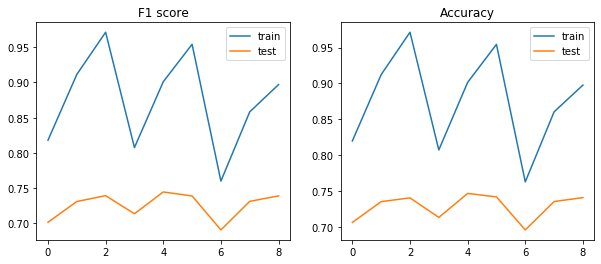

In [66]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('F1 score')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_train_f1_macro'], label='train')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_test_f1_macro'], label='test')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_train_accuracy'], label='train')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_test_accuracy'], label='test')
plt.legend(loc='best')

### Čuvanje i evaluacija najboljeg modela

In [55]:
best_model = grid_f_cnn.best_estimator_

In [57]:
import joblib
joblib.dump(best_model, 'cnn_fft.joblib')

['cnn_fft.joblib']

In [58]:
y_pred = grid_f_cnn.predict(X_test_fft)

In [76]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.93      0.95       690
           2       0.57      0.60      0.58       690
           3       0.61      0.64      0.63       690
           4       0.91      0.78      0.84       690
           5       0.76      0.83      0.79       690

    accuracy                           0.76      3450
   macro avg       0.76      0.76      0.76      3450
weighted avg       0.76      0.76      0.76      3450



In [78]:
print(metrics.classification_report(y_test, y_pred, output_dict=True))

{'1': {'precision': 0.9655688622754491, 'recall': 0.9347826086956522, 'f1-score': 0.9499263622974964, 'support': 690}, '2': {'precision': 0.5708333333333333, 'recall': 0.5956521739130435, 'f1-score': 0.5829787234042554, 'support': 690}, '3': {'precision': 0.6148459383753502, 'recall': 0.636231884057971, 'f1-score': 0.6253561253561254, 'support': 690}, '4': {'precision': 0.9107744107744108, 'recall': 0.7840579710144927, 'f1-score': 0.8426791277258566, 'support': 690}, '5': {'precision': 0.7586206896551724, 'recall': 0.8289855072463768, 'f1-score': 0.7922437673130194, 'support': 690}, 'accuracy': 0.7559420289855072, 'macro avg': {'precision': 0.7641286468827431, 'recall': 0.7559420289855072, 'f1-score': 0.7586368212193506, 'support': 3450}, 'weighted avg': {'precision': 0.7641286468827431, 'recall': 0.7559420289855072, 'f1-score': 0.7586368212193507, 'support': 3450}}


In [77]:
print('Accuracy na testnom skupu je ', metrics.classification_report(y_test, y_pred, output_dict=True)['accuracy'])

Accuracy na testnom skupu je  0.7559420289855072


In [81]:
print('F1 score na testnom skupu je ', metrics.classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score'])

F1 score na testnom skupu je  0.7586368212193506


In [68]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[645  33   3   8   1]
 [ 16 411 230   5  28]
 [  1 223 439   3  24]
 [  5  11   4 541 129]
 [  1  42  38  37 572]]


(5.5, -0.5)

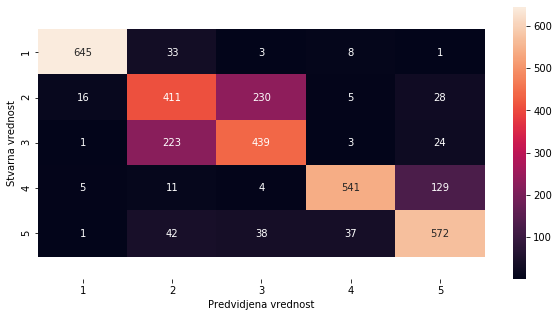

In [69]:
import seaborn
df_cm = pd.DataFrame(cm, index = classes, columns=classes)
plt.figure(figsize = (10, 5))
ax = seaborn.heatmap(df_cm, annot=True, fmt="d")
ax.set_ylabel('Stvarna vrednost')
ax.set_xlabel('Predvidjena vrednost')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)